In [2]:
import warnings

warnings.simplefilter(action ='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Input,concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import PIL
import shutil
import random
import glob
import itertools
import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [3]:
meta_data = pd.read_csv(r"C:\Users\DeLL\Desktop\Skin caner testing\skin_cancer_dataset\HAM10000_metadata.csv")
meta_data.head()
meta_data.isnull().sum()
meta_data.dropna(inplace=True)

In [4]:
meta_data.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [5]:
print("Unique Cancer types represented in data")
print(meta_data.dx.unique(),"\n")

Unique Cancer types represented in data
['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec'] 



In [6]:
image_dir_path = r'C:\Users\DeLL\Desktop\Skin caner testing\skin_cancer_dataset\Skin Cancer'

# Get a list of all files in the directory
files = os.listdir(image_dir_path)

# Filter out only the image files
image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]

# Count the number of image files
num_images = len(image_files)

print("Number of images:", num_images)

Number of images: 10015


In [7]:
new_label = "df, vasc, akiec, bcc"
label = ["df","vasc","akiec","bcc"]
meta_data['dx_new'] = ''
for i, value in enumerate(meta_data['dx']):
    if value in label:
        meta_data['dx_new'][i] = new_label
    else:
        meta_data['dx_new'][i] = value

C:\Users\DeLL\AppData\Local\Temp\ipykernel_32872\3383217166.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data['dx_new'][i] = value
C:\Users\DeLL\AppData\Local\Temp\ipykernel_32872\3383217166.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data['dx_new'][i] = value
C:\Users\DeLL\AppData\Local\Temp\ipykernel_32872\3383217166.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data['dx_new'][i] = value
C:\Users\D

In [8]:
meta_data['dx_new'].value_counts()

dx_new
nv                      6615
mel                     1109
df, vasc, akiec, bcc    1098
bkl                     1079
                          57
Name: count, dtype: int64

In [9]:
def trim(df=None,max_size = None, min_size = None, label= None):
    groups = df.groupby(label)
    trim_df = pd.DataFrame(columns=df.columns)
    for label in df[label].unique():
        group = groups.get_group(label)
        len = group.shape[0]
        if len > max_size :
            sample_group = group.sample(n=max_size)
            trim_df = pd.concat([trim_df,sample_group],axis=0)
        else: 
            if len >= min_size:
                trim_df = pd.concat([trim_df,group],axis=0)
        
    return trim_df
df = trim(meta_data,1200,900,label="dx_new")
df['dx_new'].value_counts()

dx_new
nv                      1200
mel                     1109
df, vasc, akiec, bcc    1098
bkl                     1079
Name: count, dtype: int64

In [10]:
file_dir = "./dataset/"
# Create directory if they do not exist
os.makedirs(file_dir, exist_ok=True)

In [11]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dx_new          0
dtype: int64

In [12]:
df.dropna(inplace=True)

In [13]:
df[df['localization']=="unknown"]

lesion_id      image_id   dx dx_type   age     sex localization dx_new
50    HAM_0003670  ISIC_0030105  bkl   histo  80.0  female      unknown    bkl
56    HAM_0003569  ISIC_0027960  bkl   histo  75.0    male      unknown    bkl
57    HAM_0003569  ISIC_0026955  bkl   histo  75.0    male      unknown    bkl
140   HAM_0002774  ISIC_0029683  bkl   histo  65.0    male      unknown    bkl
461   HAM_0005527  ISIC_0031819  bkl   histo  50.0    male      unknown    bkl
...           ...           ...  ...     ...   ...     ...          ...    ...
1323  HAM_0007165  ISIC_0026622  mel   histo  80.0    male      unknown    mel
1338  HAM_0001328  ISIC_0028442  mel   histo  75.0    male      unknown    mel
1344  HAM_0004265  ISIC_0026296  mel   histo  45.0    male      unknown    mel
1345  HAM_0004265  ISIC_0025018  mel   histo  45.0    male      unknown    mel
1400  HAM_0006751  ISIC_0024400  mel   histo  75.0  female      unknown    mel

[62 rows x 8 columns]

In [14]:
encoder = LabelEncoder()
df['dx_type'] = encoder.fit_transform(df['dx_type'])
print(encoder.classes_, df['dx_type'].unique())
df['localization'] = encoder.fit_transform(df['localization'])
print(encoder.classes_, df['localization'].unique())
df['sex'] = encoder.fit_transform(df['sex'])
print(encoder.classes_,df['sex'].unique())

['confocal' 'consensus' 'follow_up' 'histo'] [3 0 1 2]
['abdomen' 'acral' 'back' 'chest' 'ear' 'face' 'foot' 'genital' 'hand'
 'lower extremity' 'neck' 'scalp' 'trunk' 'unknown' 'upper extremity'] [11  4  5  2 12  3 14  0 13  9  7 10  8  6  1]
['female' 'male' 'unknown'] [1 0 2]


In [15]:
train_df, dump_df = train_test_split(df, stratify=df['dx_new'], test_size=0.2)
test_df, val_df = train_test_split(dump_df, stratify=dump_df['dx_new'], test_size=0.2)

In [16]:
def copy_images(df,new_path):
    cancer_types = df["dx_new"].unique()
    # Copy images to separated directories based on cancer type
    for cancer_type in cancer_types:
        # Create a directory for the current cancer type within the train directory
        cancer_train_dir = os.path.join(new_path,cancer_type)
        if os.path.isdir(cancer_train_dir) :
            shutil.rmtree(cancer_train_dir)
        os.makedirs(cancer_train_dir, exist_ok= True)
        # Filter images corresponding to the current cancer type
        images_of_cancer_type = df[df["dx_new"] == cancer_type]["image_id"].values
        
        # Copy images to the directory for the current cancer type
        for image_id in images_of_cancer_type:
            image_file = image_id + ".jpg"  # Assuming all image files have '.jpg' extension
            source_path = os.path.join(image_dir_path, image_file)
            destination_path = os.path.join(cancer_train_dir, image_file)
            shutil.copy(source_path, destination_path)

In [17]:
file_type = ['train_data','val_data','test_data']
df = [train_df, val_df,test_df]
for i, file in enumerate(file_type):
    new_path = os.path.join(file_dir,file)
    os.makedirs(new_path, exist_ok=True)
    copy_images(df[i], new_path)
    

In [18]:
train_dir = "./dataset/train_data"
test_dir = "./dataset/test_data"
val_dir = "./dataset/val_data"

In [19]:
subdirs = [subdir for subdir in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, subdir))]

# Print the subdirectories and count of images in each subdirectory
for subdir in subdirs:
    subdir_path = os.path.join(train_dir, subdir)
    num_images = len(os.listdir(subdir_path))
    print(f"Subdirectory: {subdir}, Number of Images: {num_images}")

Subdirectory: bkl, Number of Images: 863
Subdirectory: df, vasc, akiec, bcc, Number of Images: 878
Subdirectory: mel, Number of Images: 887
Subdirectory: nv, Number of Images: 960


2024-07-05 14:50:40,035 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-07-05 14:50:40,039 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-07-05 14:50:40,070 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-07-05 14:50:40,071 - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\DeLL\\python\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2024-07-05 14:50:40,073 - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\DeLL\\python\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
2024-07-05 14:50:40,073 - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\DeLL\\py

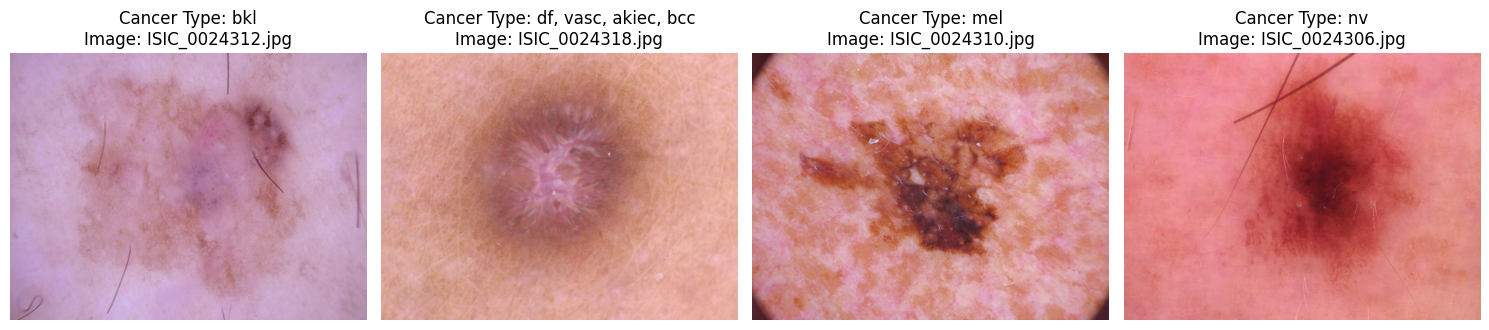

In [20]:
plt.figure(figsize=(15, 10))
for i, subdir in enumerate(subdirs):
    subdir_path = os.path.join(train_dir, subdir)
    # Get the list of image files in the subdirectory
    image_files = [file for file in os.listdir(subdir_path) if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]
    # Select the first image from the subdirectory
    if image_files:
        first_image_path = os.path.join(subdir_path, image_files[0])
        image = Image.open(first_image_path)
        # Plot the image
        plt.subplot(3, 4, i+1)  # Adjust the subplot parameters as needed
        plt.imshow(image)
        plt.title(f"Cancer Type: {subdir}\nImage: {image_files[0]}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
image_size = (224, 224)
batch_size = 32

# Create an ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input, rescale=1./255)
# datagen = ImageDataGenerator(rescale=1./255)
# Create the train_batches using flow_from_directory
train_batches = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=['mel', 'nv',  'bkl',"df, vasc, akiec, bcc"]
)

# Create the test_batches using flow_from_directory
test_batches = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=['mel', 'nv',  'bkl',"df, vasc, akiec, bcc"]
)

# Create the valid_batches using flow_from_directory
valid_batches = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=['mel', 'nv',  'bkl',"df, vasc, akiec, bcc"]
)

Found 3588 images belonging to 4 classes.
Found 718 images belonging to 4 classes.
Found 180 images belonging to 4 classes.


In [22]:
train_df.shape

(3588, 8)

In [23]:
assert train_batches.n == train_df.shape[0]


In [24]:
additional_features = train_df[['age', 'sex', 'localization','dx_type']].values
additional_features_val = val_df[['age', 'sex', 'localization','dx_type']].values

In [25]:
std = StandardScaler()
additional_features = std.fit_transform(additional_features)
additional_features_val = std.transform(additional_features_val)

In [26]:
image_input = Input(shape=(224, 224, 3), name='image_input')
additional_input = Input(shape=(4,), name='additional_input')

In [27]:
cnn_output = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(image_input)
cnn_output = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(cnn_output)
cnn_output = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(cnn_output)
cnn_output = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(cnn_output)
cnn_output = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(cnn_output)
cnn_output = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(cnn_output)
cnn_output = tf.keras.layers.Conv2D(254, (3, 3), activation='relu')(cnn_output)
cnn_output = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(cnn_output)
cnn_output = tf.keras.layers.Flatten()(cnn_output)

In [28]:
# vgg_model = tf.keras.applications.VGG16(include_top=False, input_tensor=image_input)
# cnn_output = Flatten()(vgg_model.output)

In [29]:
merged = concatenate([cnn_output, additional_input])

# Add Dense layers for combined model
x = Dense(512, activation='relu')(merged)
# x = Dense(312, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

In [30]:
model = Model(inputs=[image_input, additional_input], outputs=output)

In [31]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 52, 52,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 26, 26,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │    292,862 │ max_pooling2d_2[… │
│                     │ 254)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 12, 12,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 254)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 36576)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additional_input    │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 36580)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ additional_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │ 18,729,472 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │      2,052 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,117,634 (72.93 MB)

 Trainable params: 19,117,634 (72.93 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
additional_features.shape, (len(train_batches))*32

((3588, 4), 3616)

In [34]:
def combined_generator(image_gen, additional_features):
    batch_index = 0
    while True:
        img_batch, labels = next(image_gen)
        start = batch_index * 32
        end = start + len(img_batch)
        additional_batch = additional_features[start:end]
        # print(additional_batch)
        batch_index += 1
        if batch_index >= len(image_gen)-1:
            batch_index = 0
        yield (np.array(img_batch), np.array(additional_batch)), np.array(labels)

In [35]:
# Create the generator instance
generator_instance_train = combined_generator(train_batches, additional_features)
generator_instance_val = combined_generator(valid_batches, additional_features_val)


In [36]:
# history = model.fit(generator_instance_train,validation_data=generator_instance_val, validation_steps=6,validation_batch_size=32,steps_per_epoch=112,epochs=3)

In [37]:
from tensorflow.keras.models import load_model
model = load_model('skin_cancer_model.h5')

2024-07-05 14:50:43,801 - DEBUG - Creating converter from 3 to 5
2024-07-05 14:50:44,056 - WARNING - Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


In [38]:
# # Extracting metrics
# metrics = model.history

# train_loss = metrics["loss"]
# train_accuracy = metrics["accuracy"]

# test_loss = metrics["val_loss"]
# test_accuracy = metrics["val_accuracy"]

# # Visualizing metrics
# plt.figure(figsize = (13,4))
# plt.subplot(1,2,1)
# plt.title("Loss.")
# plt.plot(train_loss, label = "Train");
# plt.plot(test_loss, label = "Test");
# plt.grid(True)
# plt.legend(loc = "best");

# plt.subplot(1,2,2)
# plt.title("Accuracy.")
# plt.plot(train_accuracy, label = "Train");
# plt.plot(test_accuracy, label = "Test");
# plt.grid(True)
# plt.legend(loc = "best");

In [39]:
additional_features_test = test_df[['age', 'sex', 'localization','dx_type']].values
additional_features_test = std.transform(additional_features_test)
pred_data = combined_generator(test_batches,additional_features_test)

In [40]:
x_test, y_test = next(pred_data)

In [41]:
predictions = model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


In [42]:
pred = np.round(predictions),

In [43]:
len(pred[0]),len(y_test)

(32, 32)

In [44]:

# # Generate classification report
report = classification_report(y_test,pred[0])
print(report)

              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.67      0.40      0.50         5
           2       0.82      0.69      0.75        13
           3       0.80      0.57      0.67         7

   micro avg       0.79      0.59      0.68        32
   macro avg       0.77      0.56      0.65        32
weighted avg       0.79      0.59      0.67        32
 samples avg       0.59      0.59      0.59        32



c:\Users\DeLL\python\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [51]:
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

array([0, 2, 1, 1, 2, 1, 3, 2, 2, 2, 3, 1, 2, 1, 1, 2, 3, 2, 2, 1, 1, 2,
       3, 0, 2, 0, 0, 2, 2, 0, 2, 3], dtype=int64)

In [45]:
# model.save("skin_cancer_model.h5")

In [47]:
import joblib 
joblib.dump(std,"StandardScaler.lb")

['StandardScaler.lb']